In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.animation import FuncAnimation, writers

from tqdm import tqdm


%matplotlib inline

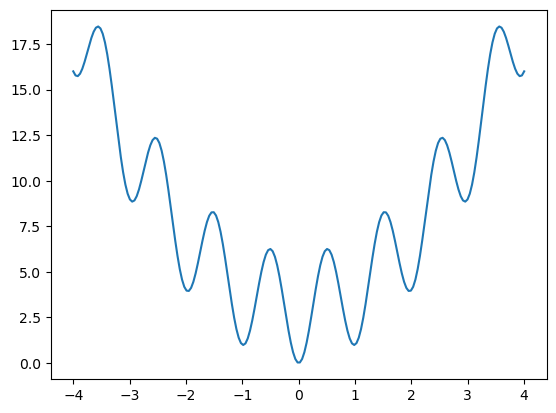

In [2]:
def rastrian_function(x, A):
    return A + x ** 2 - A * torch.cos(2 * torch.pi * x)

rast1 = lambda x: rastrian_function(x, 3)

# X = np.linspace(-4, 4, 200)
X = torch.linspace(-4, 4, 200)
y = [rast1(x) for x in X]

plt.plot(X,y)

plt.show()

##### run_optimizer

In [81]:
from torch.autograd import Variable

x_traj = []
A=3.0

x_list = []

def generate_random(upper, lower, shape):
    return lower + torch.rand(shape) * (upper - lower)

def run_optimize(N, objective, optimizer, early_stop_norm=1e-4, verbose=False):
    x_traj = []
    
    x = generate_random(-4, 4, N)
    if verbose: print("Initial condition:", x)
    x.requires_grad = True
    

    optim = optimizer([x])

    # Optimize the objective function
    for _ in range(int(1e4)):
        y = torch.sum(objective(x)) # summation doesn't affect the gradient
        optim.zero_grad()
        y.backward()
        
        # If the gradient is small, early stop
        if x_traj and np.linalg.norm(x.detach().numpy() - x_traj[-1]) < early_stop_norm:
            if verbose: print("Stopping gradient:", x.grad)
            break
            
        x_traj.append(x.detach().numpy().copy())
        
        optim.step()
    
    return x_traj

optimizer = partial(torch.optim.SGD, lr=1e-4)
x_traj = run_optimize(2, rast1, optimizer)


##### plot_result

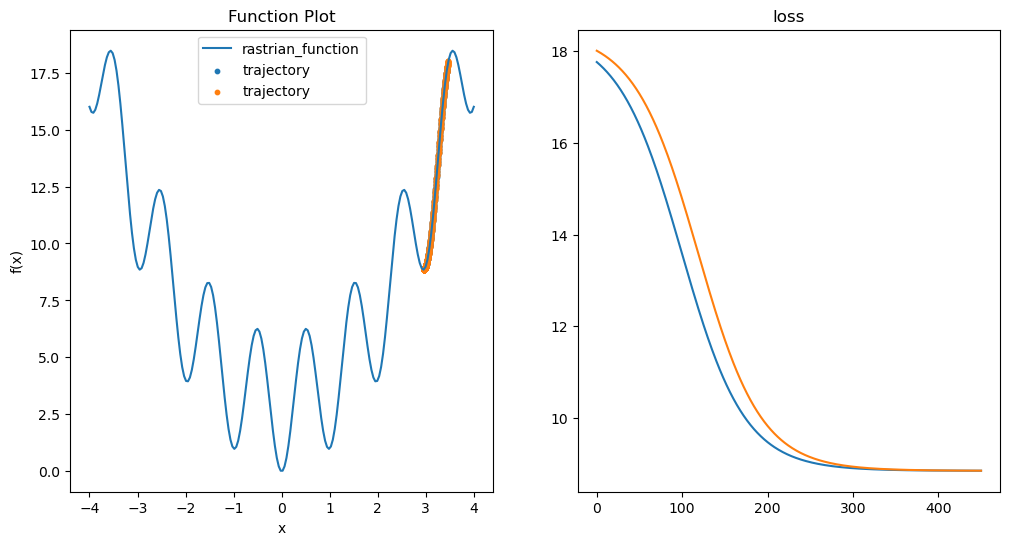

In [82]:
# Generate the function plot
def plot_function(ax, func, linspace, **kwargs):
    ax.plot(linspace, func(linspace), **kwargs)

def plot_result(x_traj, objective):

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    plot_function(ax[0], 
                  rast1, 
                  torch.linspace(-4, 4, 200),
                  label='rastrian_function')
    # ax[0].plot(x, y, label='rastrian_function')

    # Plot the trajectory points
    x_traj = torch.tensor(np.array(x_traj))
    y_traj = rast1(x_traj)

    for i in range(len(x_traj[0])):
        ax[0].scatter(x_traj[:, i], y_traj[:, i], label='trajectory', s=10)

    # Add labels and title
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('f(x)')
    ax[0].set_title('Function Plot')

    # Add legend
    ax[0].legend()

    ax[1].plot(y_traj)
    ax[1].set_title("loss")

    # Show the plot
    plt.show()

plot_result(x_traj, rast1)

##### Gif plotting

In [8]:
from IPython.display import HTML

# Generate the function plot
def plot_animate(x_traj):
    fig, ax = plt.subplots()

    def animation_function(t, x_traj):
        ax.cla()

        plot_function(ax, 
                      rast1, 
                      torch.linspace(-4, 4, 100),
                      label='rastrian_function')

        # Plot the trajectory points
        x_traj = torch.tensor(np.array(x_traj))
        y_traj = rast1(x_traj)

        for i in range(len(x_traj[0])):
            ax.scatter(x_traj[t, i], y_traj[t, i], label='trajectory', s=20)

        # Add labels and title
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title('Function Plot')


    def init():
        ax.set_xlim(-4, 4)

    print("Total number of frames:", len(x_traj))
    animation = FuncAnimation(fig, partial(animation_function, x_traj=x_traj), frames = np.arange(len(x_traj)),
                              interval = 100, blit=False)

    animation.save("func.gif")
    return animation

# animation = plot_animate(x_traj)
# HTML(animation.to_html5_video())


## Experiments

In [89]:
# Do the experiment

def experiment(
    N,
    objective,
    optimizer,
    sample_size,
    optimum,
    tol,
):

    success = 0

    x_last = []

    losses = []

    for _ in tqdm(range(sample_size)):
        x_traj = run_optimize(N, objective, optimizer)
        x_last.append(x_traj[-1])
        losses.append(objective(torch.tensor(x_traj[-1])))
        if np.linalg.norm(x_traj[-1] - optimum) < tol:
            success += 1
    print("The sucess rate is", success/sample_size)
    
    return {
        'x_last': x_last,
        'losses': losses
    }

optimizer = partial(torch.optim.SGD, lr=1e-4)
result = experiment(1, rast1, optimizer, int(1e4), 0, 0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:09<00:00, 52.75it/s]

The sucess rate is 0.1224


In [7]:
def get_min_for_independent_trials(losses, r):
    losses = torch.tensor(losses)
    cut = len(losses) // r
    losses = losses[:r * cut]
    reshaped_loss = losses.reshape(r, -1)
    value, _ = torch.min(reshaped_loss, dim=0)
    return torch.mean(value)


average_loss = get_min_for_independent_trials(result['losses'], 3)
print("The average loss of independent trials (groups of 3) is", average_loss.item())

The average loss of independent trials (groups of 3) is 1.5595097541809082


In [58]:


class PEDS_SGD(torch.optim.SGD):
    def __init__(self, *args, **kwargs):
        if 'alpha' in kwargs:
            self.alpha = kwargs['alpha']
            del kwargs['alpha']
        else:
            self.alpha = 1
        super(PEDS_SGD, self).__init__(*args, **kwargs)
        
    
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                param.grad.fill_(torch.mean(param.grad))
                # param.grad.fill_(0)
                N = param.numel()
                Omega1 = torch.full((N, N), 1.0/N)
                param.grad.add_(torch.matmul(self.alpha * (torch.eye(N) - Omega1), param))
        super(PEDS_SGD, self).step()
                # param.add_(param.grad)



In [85]:
len(x_traj[::step])

103

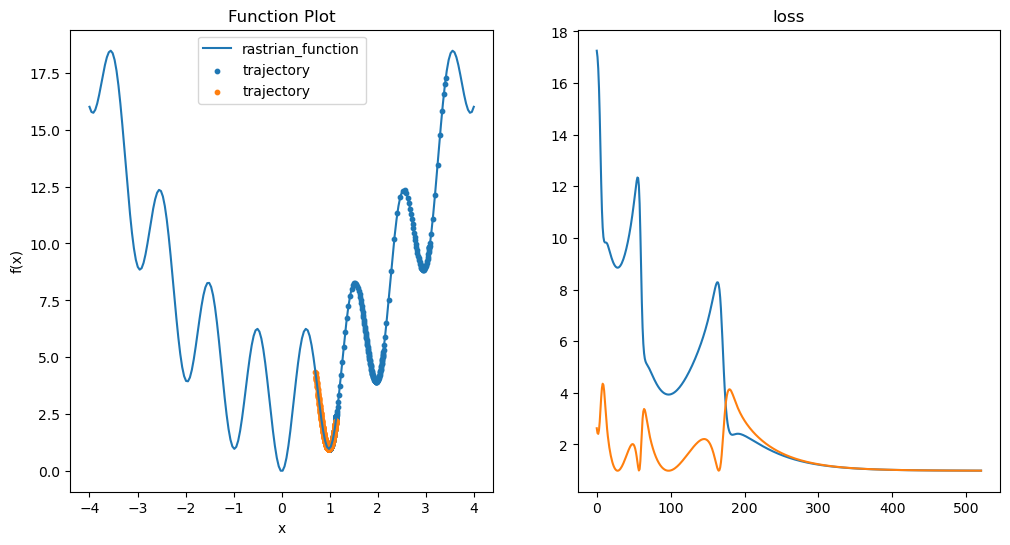

Total number of frames: 105


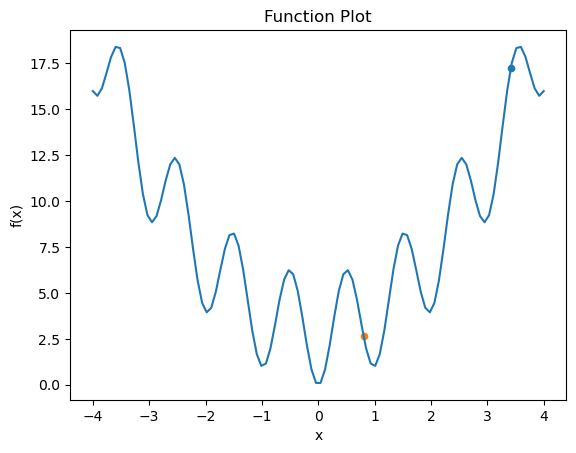

In [86]:
optimizer = partial(PEDS_SGD, alpha=1, lr=1e-2)
x_traj = run_optimize(2, rast1, optimizer)
plot_result(x_traj, rast1)

step = len(x_traj)//100
animation = plot_animate(x_traj[::step])

In [9]:
result = experiment(3, rast1, PEDS_SGD, int(1e2), 0, 0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]

The sucess rate is 0.42


In [10]:

average_loss = np.mean([i.numpy() for i in result['losses']]) 
print("The average loss for PEDS for N=3 is", average_loss)

The average loss for PEDS for N=3 is 1.406149


In [159]:
!ls -l *.pkl

-rw-r--r--  1 charliechen  staff  11002758 Jun 22 11:00 combined_for_alpha_inc0.1.pkl
-rw-rw-r--  1 charliechen  staff  11002818 Jun 21 17:10 experiment_0621_1233.pkl
-rw-rw-r--  1 charliechen  staff  13203124 Jun 21 20:21 experiment_0621_1426.pkl


| job id | m | alpha_inc |
| -- | -- | -- |
| 34814256 | 2 | 0 |
| 34814257 | 2 | 0.1 |
| 34814258 | 3 | 0 |
| 34814259 | 3 | 0.1 |

In [ ]:
# c1436e7
# run_cpu_job-34755957.out
# experiment_0620_1740.pkl

In [214]:
import glob
import pickle
import json

meta_data_list = []
data_list = []

for file_path in glob.glob('*.pkl'):
    print(file_path)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        meta_data = data[0]
        data = data[1:]
        meta_data_list.append(meta_data)
        data_list.append(data)
        
# Pretty print meta_data_list
[print(meta_data) for meta_data in meta_data_list]
[len(data) for data in data_list]
# data_list[1]


experiment_m3_alphainc0.1_0622_1142.pkl
experiment_m5_alphainc0.1_0622_1822.pkl
experiment_m2_alphainc0.1_0622_1822.pkl
experiment_m3_alphainc0.1_0622_1822.pkl
experiment_m3_alphainc0.0_0622_1142.pkl
experiment_m2_alphainc0.1_0622_1142.pkl
experiment_m4_alphainc0.1_0622_1822.pkl
experiment_m2_alphainc0.0_0622_1138.pkl
experiment_m6_alphainc0.1_0622_1822.pkl
{'naive': False, 'alpha': 1, 'alpha_inc': 0.1, 'm': 3, 'lower_N': 1, 'upper_N': 10, 'lr': 0.0001, 'sample_size': 10000, 'A': 3, 'seed': 42}
{'naive': False, 'alpha': 1, 'alpha_inc': 0.1, 'm': 5, 'lower_N': 1, 'upper_N': 10, 'lr': 0.0001, 'sample_size': 10000, 'A': 3, 'seed': 42}
{'naive': False, 'alpha': 1, 'alpha_inc': 0.1, 'm': 2, 'lower_N': 11, 'upper_N': 20, 'lr': 0.0001, 'sample_size': 10000, 'A': 3, 'seed': 42}
{'naive': False, 'alpha': 1, 'alpha_inc': 0.1, 'm': 3, 'lower_N': 11, 'upper_N': 20, 'lr': 0.0001, 'sample_size': 10000, 'A': 3, 'seed': 42}
{'naive': False, 'alpha': 1, 'alpha_inc': 0.0, 'm': 3, 'lower_N': 1, 'upper_N'

[10, 10, 10, 10, 10, 10, 10, 10, 10]

In [209]:
def compare_meta(meta1, meta2):
    for k in meta1.keys():
        if 'N' in k: continue
        if meta1[k] != meta2[k]:
            return False
    return True

l = len(data_list)
new_data = []
new_meta_data = []
for i in range(l):
    data = data_list[i]
    meta_data = meta_data_list[i]
    for j in range(i+1, l):
        meta1, meta2 = meta_data_list[i], meta_data_list[j]
        if compare_meta(meta1, meta2):
            print(i, j)
    # new_data.append(data)
    # new_meta_data.append(meta_data)
            
            

0 3
2 5


In [208]:
data_list[0][2].keys()

dict_keys(['N', 'last_x', 'mean_loss', 'success_rate', 'total_time'])

In [230]:
def sort_array_based_on_other(array1, array2):
    zipped = zip(array2, array1)  # Combine the arrays into tuples
    sorted_pairs = sorted(zipped)  # Sort the tuples based on the values of array2
    _, sorted_array1 = zip(*sorted_pairs)  # Unzip the sorted tuples
    return list(sorted_array1)  # Convert the result back to a list


Length: 10
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
(0.0006, 0.0246, 0.0072, 0.0528, 0.0462, 0.1029, 0.119, 0.1601, 0.2079, 0.2517)


Text(0.5, 1.0, 'Increase alpha by 0.1 in each step\n m=6 alpha_inc=0.1')

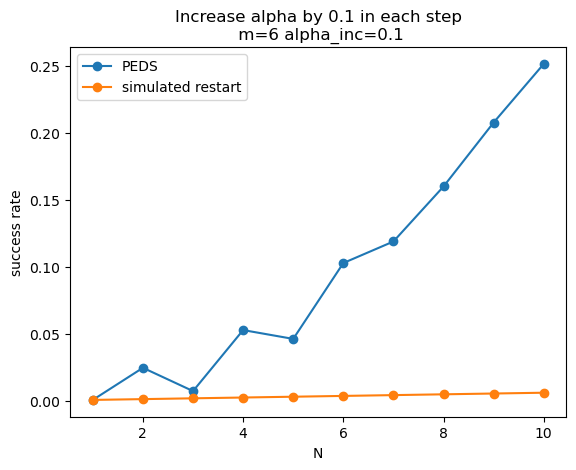

In [253]:
m=6
alpha_inc = 0.1
data = []
for i in range(len(data_list)-1,-1,-1):
    meta = meta_data_list[i]
    if meta['m'] == m and meta['alpha_inc'] == alpha_inc:
        data += data_list[i]
print("Length:",len(data))

succ = [d['success_rate'] for d in data]
X = [d['N'] for d in data]
zipped = sorted(zip(X, succ))
X, succ = zip(*zipped)
print(X)
print(succ)

simulated_restart = [1 - (1 - succ[0]) ** (N + 1) for N in range(len(succ))]
plt.plot(X, succ, 'o-', label=f'PEDS')
plt.plot(X,simulated_restart, 'o-', label=f'simulated restart')
plt.xlabel("N")
plt.legend()
plt.ylabel("success rate")
plt.title("Increase alpha by 0.1 in each step\n m={} alpha_inc={}".format(m, alpha_inc))


In [ ]:
s

[0.0154, 0.1691, 0.0842, 0.2347, 0.219, 0.3224, 0.3522, 0.4126, 0.4567, 0.5082]
[0.5407, 0.5728, 0.6224, 0.6438, 0.6805, 0.7083, 0.7309, 0.7536, 0.7846, 0.801]


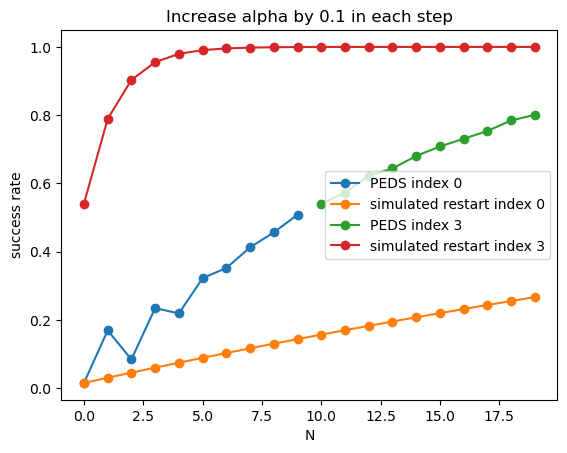

In [220]:
index_list = [0, 3]
for index in index_list:
    succ = [data['success_rate'] for data in data_list[index]]
    X = [data['N']-1 for data in data_list[index]]
    print(succ)
    simulated_restart = [1 - (1 - succ[0]) ** (N + 1) for N in range(len(succ)*2)]
    plt.plot(X, succ, 'o-', label=f'PEDS index {index}')
    plt.plot(simulated_restart, 'o-', label=f'simulated restart index {index}')

# plt.ylim(0, 1)
plt.xlabel("N")
plt.legend()
plt.ylabel("success rate")
plt.title("Increase alpha by 0.1 in each step")

plt.show()

Text(0.5, 1.0, 'Increase alpha by 0.1 in each step')

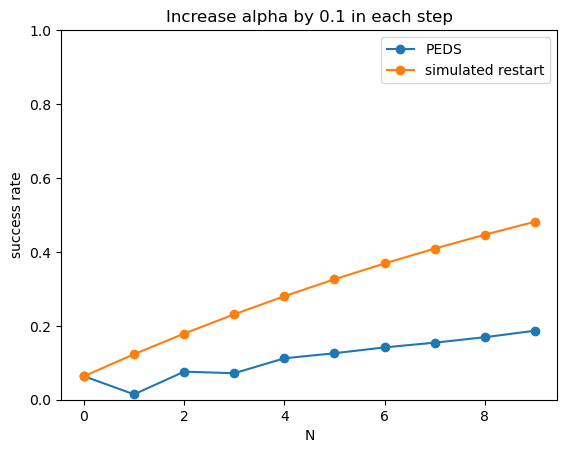

In [156]:
succ = [data[i]['success_rate'] for i in range(len(data))]
simulated_restart = [1-(1-(succ[0]))** (N+1) for N in range(len(data))]
plt.plot(succ, 'o-', label='PEDS')
plt.plot(simulated_restart, 'o-', label='simulated restart')
plt.ylim(0,1)
plt.xlabel("N")
plt.legend()
plt.ylabel("success rate")
plt.title("Increase alpha by 0.1 in each step")



N [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean_loss [2.8907142, 4.1554403, 4.1161647, 4.305192, 4.523352, 4.628428, 4.712662, 4.7768707, 4.8417587, 4.8685017]
success_rate [0.0636, 0.0146, 0.0759, 0.0717, 0.1121, 0.1258, 0.1416, 0.1544, 0.1691, 0.1867]
total_time [72.68525385856628, 499.1476364135742, 1233.3012821674347, 1518.9256179332733, 1734.63427734375, 1931.0575399398804, 2240.652900457382, 2345.4846382141113, 2464.4341921806335, 2550.724460840225]


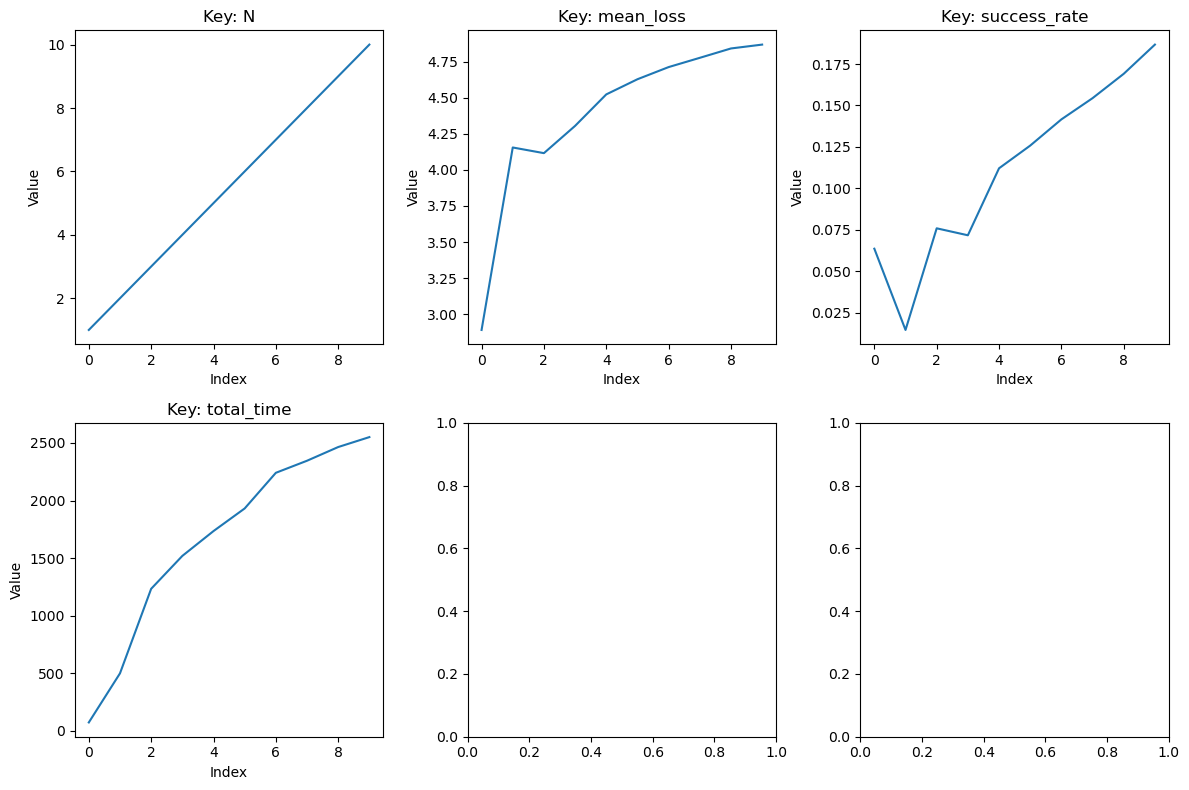

In [154]:
def plot_keys(data, keys):
    # keys = list(data[0].keys())  # Get the keys from the first element
    
    num_keys = len(keys)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_keys + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows), tight_layout=True)

    for i, key in enumerate(keys):
        ax = axs[i // num_cols, i % num_cols]
        values = [d[key] for d in data]
        print(key, values)
        ax.plot(values)
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.set_title(f'Key: {key}')

    plt.show()
plot_keys(data, ['N', 'mean_loss', 'success_rate', 'total_time'])

Text(0.5, 1.0, 'Increase alpha by 0.1 in each step')

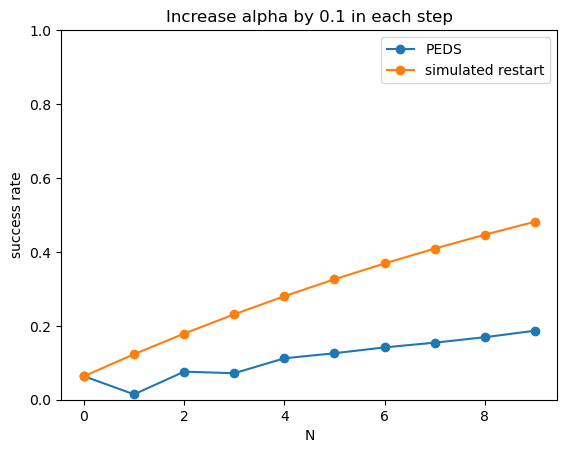